In [1]:
import os
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
from scipy.signal import find_peaks

from utils.edge import fill_rotate
from utils.edge import integral_intensity_projection
from utils.general import intersection
from utils.preprocess import rotate_point
from utils.shortcut import quick_get_tooth, quick_rotate_and_zooming, quick_get_roi

load_dotenv()
matplotlib.use('module://matplotlib_inline.backend_inline')

%matplotlib inline


/opt/miniconda3/envs/pt113/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [2]:
data_dir = Path(os.getenv('DATASET_DIR')) / 'phase-2'
data_dir


PosixPath('/Users/lucyxu/PycharmProjects/datasets/phase-2')

In [3]:
image_paths = list(data_dir.glob('00008026.jpg'))
image_path = image_paths[0]

image_path.name


'00008026.jpg'

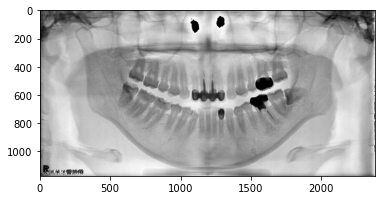

In [4]:
import cv2 as cv

im = cv.imread(str(image_path), cv.IMREAD_GRAYSCALE)

plt.gray()
plt.imshow(1 - im)
plt.show()


[ 685  233 1021  695]


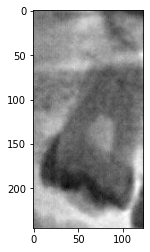

In [5]:
roi_index = 0

im_g, flag, tooth_position, teeth_roi_split_teeth, target_roi = quick_get_roi(image_path, roi_index=roi_index)
source, gum_sep_line, theta, paddings = quick_rotate_and_zooming(im_g, flag=flag, tooth_position=tooth_position)

teeth_roi_split_teeth = teeth_roi_split_teeth[image_path.stem]

tooth_number_dict = {
    'upper': {
        'left': [17, 13],
        'middle': [13, 23],
        'right': [23, 27],
    },
    'lower': {
        'left': [47, 43],
        'middle': [43, 33],
        'right': [33, 37],
    }
}

tooth_numbers = tooth_number_dict[flag][tooth_position]

tooth_im, tooth_xyxy = quick_get_tooth(image_path, str(tooth_numbers[0]))

h_0, w_0 = tooth_im.shape
target_roi_xyxy = target_roi['xyxy'].numpy()

print(target_roi_xyxy)

plt.imshow(1 - tooth_im)
plt.show()


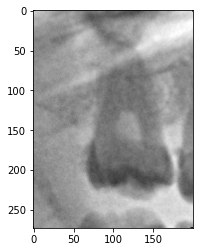

In [6]:
# a = fill_rotate(im, target_roi_xyxy, theta)
a = fill_rotate(im, tooth_xyxy, theta)

plt.imshow(1 - a)
# plt.axhline(gum_sep_line)
plt.show()


Get the intersection of gap and gum

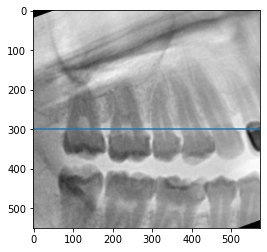

In [7]:
im_g_rotated = fill_rotate(im, target_roi_xyxy, theta, expand_size=(50, 0))

plt.imshow(1 - im_g_rotated)
plt.axhline(gum_sep_line)
plt.show()


In [8]:
def find_gap_by_tooth(im_tooth, show=True):
    h, w = im_tooth.shape

    hor, ver = integral_intensity_projection(im_tooth)
    ver_inverse = ver.max() - ver

    peaks, properties = find_peaks(ver_inverse, height=0)

    peaks_left = peaks[peaks < w / 2]
    peaks_right = peaks[peaks > w / 2]

    peaks_lowest = np.array((peaks_left[ver[peaks_left].argmin()], peaks_right[ver[peaks_right].argmin()]))

    if show:
        plt.plot(ver)
        plt.plot(peaks, ver[peaks], "x")
        plt.plot(peaks_lowest, ver[peaks_lowest], "o")
        plt.show()

        plt.imshow(1 - im_tooth)
        plt.axvline(peaks_lowest[0])
        plt.axvline(peaks_lowest[1])
        plt.show()

    gap_lines = []
    for gap in gaps:
        gap_lines.append([gap, 0])
        gap_lines.append([gap, h])
    gap_lines = np.array(gap_lines)
    return peaks_lowest, gap_lines
    # return peaks_lowest, ver[peaks_lowest]


tooth_im_rotated = fill_rotate(im, tooth_xyxy, theta)
tooth_im_rotated_equ = cv.equalizeHist(tooth_im_rotated)

gaps, gap_lines = find_gap_by_tooth(tooth_im_rotated, show=False)
# gaps, gap_lines = find_gap_by_tooth(tooth_im)

plt.imshow(1 - tooth_im_rotated)

plt.axline(*gap_lines[:2])
plt.axline(*gap_lines[2:])

plt.show()


NameError: name 'gaps' is not defined

In [ ]:
gap_line_matrix = gap_lines.copy()

gap_line_matrix = rotate_point(theta, tooth_im_rotated.shape, gap_line_matrix, recovery=True)
gap_line_matrix = gap_line_matrix + tooth_xyxy[:2]

plt.imshow(1 - im)
# for i in range(4):
#     plt.scatter(*hw_matrix[i])
plt.axline(*gap_line_matrix[:2])
plt.axline(*gap_line_matrix[2:])
plt.show()


In [ ]:
gum_rotated_matrix = np.array([[0, gum_sep_line],
                               [100, gum_sep_line]])

gum_rotated_matrix = rotate_point(theta, im_g.shape, gum_rotated_matrix, recovery=True)
gum_rotated_matrix = gum_rotated_matrix + target_roi_xyxy[:2]

plt.imshow(1 - im)
plt.axline(*gum_rotated_matrix)


In [ ]:
point1 = intersection(*gap_line_matrix[:2], *gum_rotated_matrix)
point2 = intersection(*gap_line_matrix[2:], *gum_rotated_matrix)

gaps_global = np.array([point1,
                        point2])

plt.imshow(1 - im)
plt.scatter(*point1)
plt.scatter(*point2)
plt.show()

gaps_global


In [ ]:
def find_local_gap_by_tooth(im_tooth):
    """
    This function finds the local minima of an image of a tooth.
    Args:
        im_tooth: A 2-D array representing an image of a tooth

    Returns:
        gaps: The location of the local minima in an array
        gaps_intensity: The intensity of the local minima in the image
    """
    # Get the height and width of the tooth
    h, w = im_tooth.shape

    # Get the integral intensity projection of the tooth
    hor, ver = integral_intensity_projection(im_tooth)

    # Get the inverse of the ver projection
    ver_inverse = ver.max() - ver

    # Find the peaks of the ver_inverse
    peaks, properties = find_peaks(ver_inverse, height=0)

    # Get the peaks from left and right
    peaks_left = peaks[peaks < w / 2]
    peaks_right = peaks[peaks > w / 2]

    # Get the local minima from the left and right peaks
    gaps = np.array((peaks_left[ver[peaks_left].argmin()], peaks_right[ver[peaks_right].argmin()]))
    gaps_intensity = ver[gaps]

    return gaps, gaps_intensity


# def aaa(tooth_im, tooth_xyxy, theta, global_im, gum_sep_line):
#     # Find gap beside tooth
#     tooth_im_rotated = fill_rotate(global_im, tooth_xyxy, theta)
#     gaps_r, gaps_intensity_r = find_gap_by_tooth(tooth_im_rotated)
#     gaps_o, gaps_intensity_o = find_gap_by_tooth(tooth_im)
#
#     gaps = [
#         gaps_r[0] if gaps_intensity_r[0] > gaps_intensity_o[0] else gaps_o[0],
#         gaps_r[1] if gaps_intensity_r[1] > gaps_intensity_o[1] else gaps_o[1],
#     ]
#
#     gap_lines = []
#     for gap in gaps:
#         gap_lines.append([gap, 0])
#         gap_lines.append([gap, 100])
#     gap_lines = np.array(gap_lines)
#
#     # Get gap line global
#     gap_line_matrix = rotate_point(theta, tooth_im_rotated.shape, gap_lines, recovery=True)
#     gap_line_matrix = gap_line_matrix + tooth_xyxy[:2]
#
#     gum_rotated_matrix = np.array([[0, gum_sep_line],
#                                    [100, gum_sep_line]])
#
#     # Get gum line global
#     gum_rotated_matrix = rotate_point(theta, im_g.shape, gum_rotated_matrix, recovery=True)
#     gum_rotated_matrix = gum_rotated_matrix + target_roi_xyxy[:2]
#
#     point1 = intersection(*gap_line_matrix[:2], *gum_rotated_matrix)
#     point2 = intersection(*gap_line_matrix[2:], *gum_rotated_matrix)
#
#     gaps_global = np.array([point1,
#                             point2])
#
#     return gaps_global





# Experiment